#**Credit Risk Classification Using MLP and Imbalanced Learning Techniques**
This notebook applies several machine learning classifiers to predict credit risk using the South German Credit dataset. The project focuses on dealing with class imbalance by using advanced resampling techniques such as SMOTETomek and KMeansSMOTE, and evaluates performance using metrics suited for imbalanced datasets: Recall, Precision, F1-score, and Geometric Mean (G-Mean).

The best model was a Multilayer Perceptron (MLP) classifier, which achieved the highest F1-score while maintaining a balance between identifying high-risk clients and avoiding excessive rejection of low-risk ones. The results were confirmed using cross-validation and evaluation plots (ROC and Precision-Recall curves).

This notebook corresponds to the Modeling stage of the CRISP-DM process and was developed as part of a graduate course on Artificial Intelligence and Machine Learning.


#Environment Setup and Package Imports

In [164]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from pandas import read_csv
from sklearn.model_selection import train_test_split
import seaborn as sns
import sklearn
import xgboost
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from imblearn.over_sampling import KMeansSMOTE
from sklearn.inspection import permutation_importance
from imblearn.under_sampling import RandomUnderSampler

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from imblearn.metrics import geometric_mean_score
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from imblearn.combine import SMOTETomek
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [165]:
# Disable warning messages for cleaner output
import warnings
warnings.filterwarnings('ignore')


# Load dataset
path = 'SouthGermanCredit.asc'
df = read_csv(path, delimiter=' ')
print(f"Dataset shape: {df.shape}")
df.head(3).T


Dataset shape: (1000, 21)


,0,1,2
laufkont,1,1,2
laufzeit,18,9,12
moral,4,4,2
verw,2,0,9
hoehe,1049,2799,841
sparkont,1,1,2
beszeit,2,3,4
rate,4,2,2
famges,2,3,2
buerge,1,1,1


In [166]:
# Rename columns to more descriptive names
df.columns = [
    'account', 'duration', 'creditworthiness', 'purpose', 'amount', 'savings',
    'employment_duration', 'installment_rate', 'personal_status', 'guarantor',
    'residence_duration', 'assets', 'age', 'other_loans', 'housing',
    'existing_credits', 'job', 'people_liable', 'phone', 'foreign_worker',
    'credit_risk'
]
df.head(3).T


,0,1,2
account,1,1,2
duration,18,9,12
creditworthiness,4,4,2
purpose,2,0,9
amount,1049,2799,841
savings,1,1,2
employment_duration,2,3,4
installment_rate,4,2,2
personal_status,2,3,2
guarantor,1,1,1


#Class Label Inversion (Target Re-labeling)

In [167]:
# Check original class distribution
print(df['credit_risk'].value_counts())


credit_risk
1    700
0    300
Name: count, dtype: int64


In [168]:
# Invert class labels so that the minority class is positive (1)
df['credit_risk'] = df['credit_risk'].apply(lambda x: 1 if x == 0 else 0)

# Check new class distribution
print(df['credit_risk'].value_counts())


credit_risk
0    700
1    300
Name: count, dtype: int64


**Observation:**

The target variable was redefined so that 1 now represents high credit risk. This aligns with standard binary classification setups, where the positive class is the minority and of greater interest for model performance evaluation.

#Dataset Splitting and Class Imbalance Analysis

In [169]:

# Separate features and target
y = df['credit_risk'].to_frame()
X = df.drop('credit_risk', axis=1)

# Perform stratified split (70% train, 30% test)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, stratify=y, random_state=32)

# Display dataset shapes
print("Shapes:")
print("Train:", Xtrain.shape, ytrain.shape)
print("Test:", Xtest.shape, ytest.shape)

# Show class distribution in training set
positive_ratio = (ytrain.sum() / ytrain.shape[0]).iloc[0]
print("\nClass Distribution (Training Set):")
print("Negative (good clients - 0): %.2f%%, Positive (bad clients - 1): %.2f%%" % (100 * (1 - positive_ratio), 100 * positive_ratio))


Shapes:
Train: (700, 20) (700, 1)
Test: (300, 20) (300, 1)

Class Distribution (Training Set):
Negative (good clients - 0): 70.00%, Positive (bad clients - 1): 30.00%


**Observation:**

The dataset was split using stratified sampling. The training set has a moderate imbalance: ~70% negative class (good clients) and ~30% positive class (bad clients).

There is a moderate imbalance in the training data. The majority class (good clients) accounts for ~70% of the samples, while the minority class (bad clients) is ~30%.  
This may cause the model to struggle identifying bad clients. Sampling techniques such as oversampling or undersampling may help.


#Feature Categorization Based on Data Types

In [170]:
# Define input variables according to Table 3 of the associated IEEE article.

# Numerical variables
numerical_features = ["duration", "amount", "age", "people_liable"]

# Ordinal variables
ordinal_features = [
    "account", "savings", "employment_duration", "installment_rate",
    "residence_duration", "assets", "other_loans", "housing",
    "existing_credits", "job"
]

# Nominal and binary variables
categorical_features = [
    "creditworthiness", "purpose", "personal_status", "guarantor",
    "phone", "foreign_worker"
]

print("Input feature distribution by type:")
print("Numerical variables:", len(numerical_features))
print("Ordinal variables:", len(ordinal_features))
print("Nominal & binary variables:", len(categorical_features))


Input feature distribution by type:
Numerical variables: 4
Ordinal variables: 10
Nominal & binary variables: 6


**Observation**

The dataset features are split into 3 types:

* 4 numerical

* 10 ordinal

* 6 categorical/binary

This categorization is essential for applying the right preprocessing strategy in the next steps.

# Exploratory Data Analysis & Preprocessing Pipelines

In [171]:
# Summary statistics for all input features
Xtrain.describe(include='all').T


,count,mean,std,min,25%,50%,75%,max
account,700.0,2.570000,1.249647,1.0,1.0,2.0,4.00,4.0
duration,700.0,21.141429,12.377063,4.0,12.0,18.0,24.00,72.0
creditworthiness,700.0,2.512857,1.099411,0.0,2.0,2.0,4.00,4.0
purpose,700.0,2.844286,2.752558,0.0,1.0,2.0,3.00,10.0
amount,700.0,3265.477143,2790.088119,276.0,1382.0,2327.0,3972.25,18424.0
savings,700.0,2.111429,1.581052,1.0,1.0,1.0,3.00,5.0
employment_duration,700.0,3.401429,1.186596,1.0,3.0,3.0,5.00,5.0
installment_rate,700.0,2.992857,1.128994,1.0,2.0,3.0,4.00,4.0
personal_status,700.0,2.658571,0.717050,1.0,2.0,3.0,3.00,4.0
guarantor,700.0,1.147143,0.487093,1.0,1.0,1.0,1.00,3.0


**Observation:**

This statistical summary (mean, std, min, max, etc.) helps detect missing values, outliers, and distributions across variables to inform preprocessing decisions.

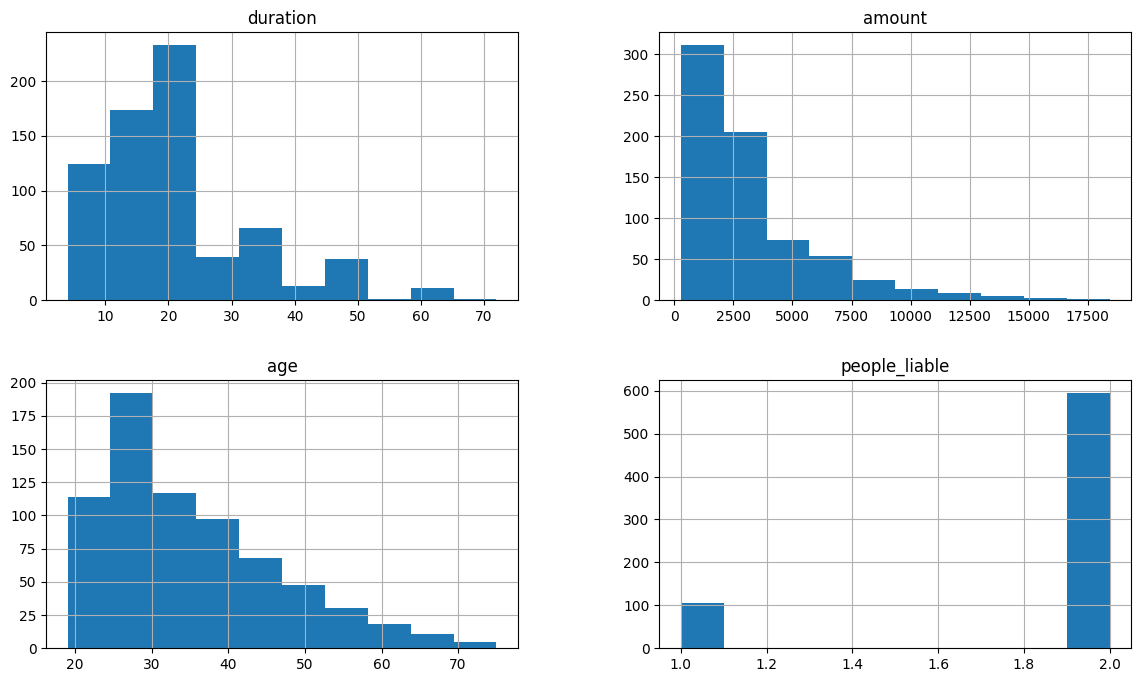

In [172]:
# Distribution of numerical features
Xtrain[numerical_features].hist(figsize=(14, 8))
plt.show()


**Observation:**

Histograms show skewness in all numeric features. This suggests a transformation (e.g., power transformation) may help normalize the distributions.

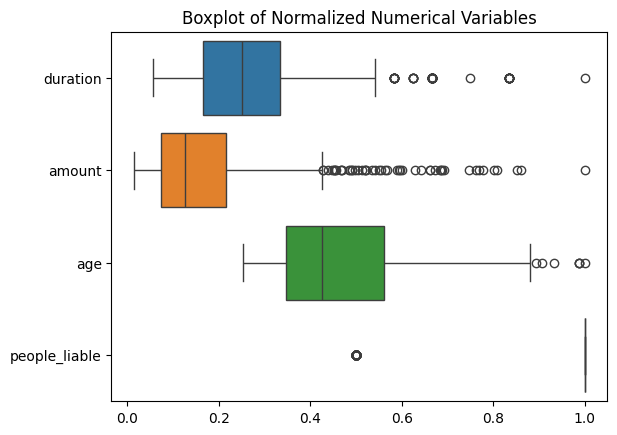

In [173]:
# Normalized boxplots of numerical variables
normalized_df = Xtrain[numerical_features] / Xtrain[numerical_features].max()
sns.boxplot(data=normalized_df, orient='y')
plt.title("Boxplot of Normalized Numerical Variables")
plt.show()


**Observation:**

The boxplots confirm the presence of outliers and different scales across variables, reinforcing the need for transformation and scaling.

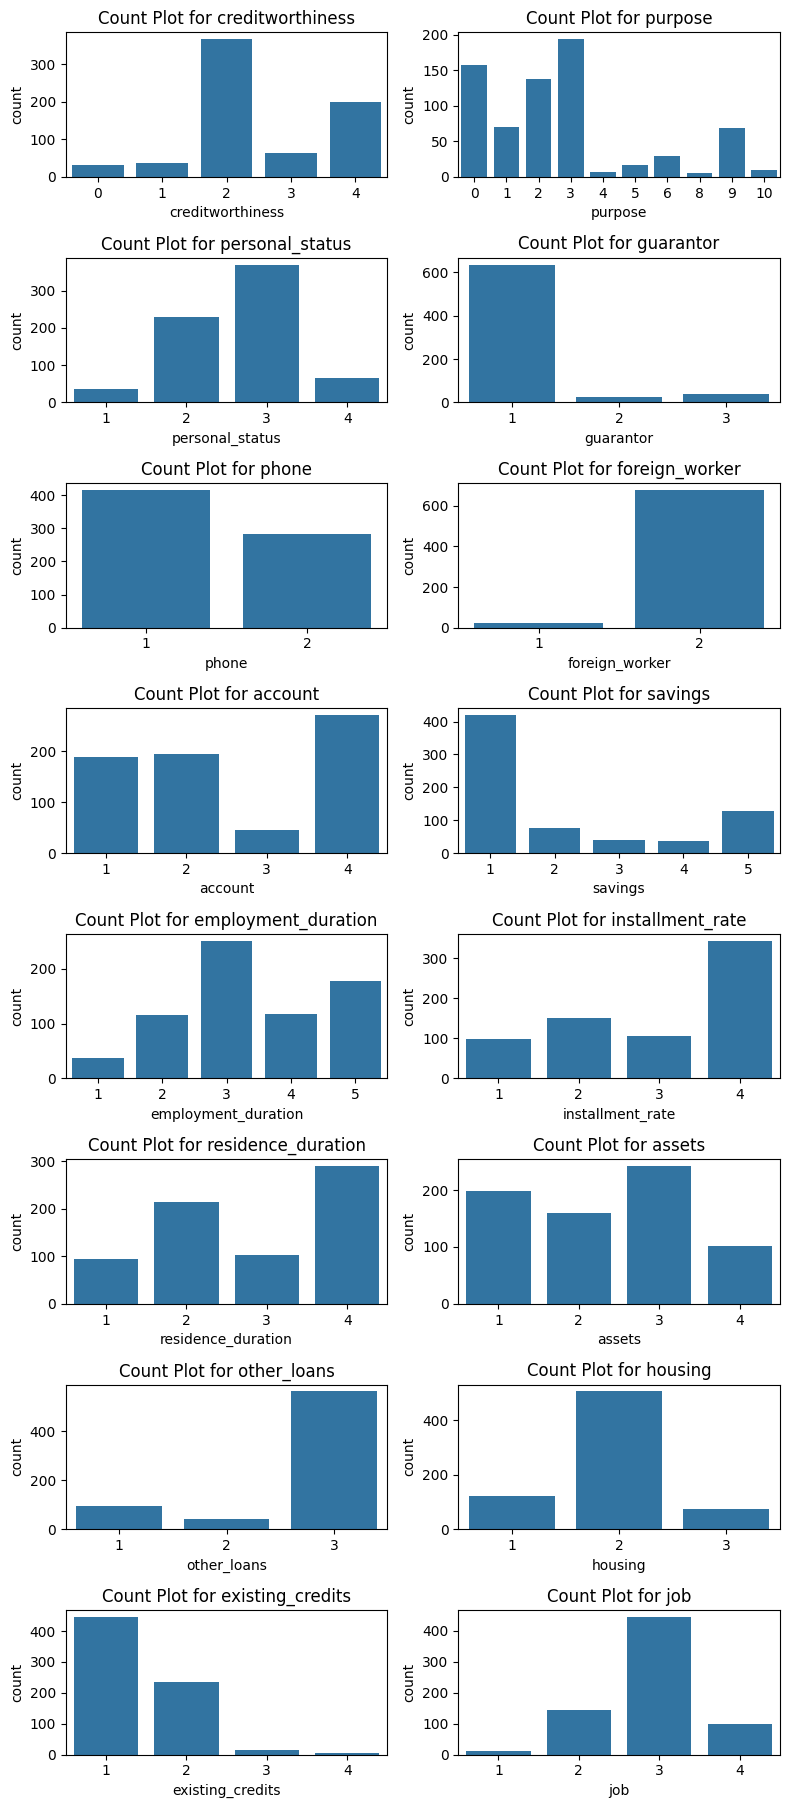

In [174]:
# Count plots of categorical and ordinal variables
plt.figure(figsize=(8, 20))
for i, col in enumerate(categorical_features + ordinal_features):
    plt.subplot(9, 2, i + 1)
    sns.countplot(data=Xtrain, x=col)
    plt.title(f'Count Plot for {col}')

plt.tight_layout()
plt.show()


**Observation:**

These visualizations reveal class imbalance and low-cardinality features, guiding appropriate encoding strategies like OneHot or Ordinal encoding.

In [175]:
# Numerical pipeline: median imputation + Yeo-Johnson transform + scaling
numerical_pipeline = Pipeline(steps=[
    ('median_imputer', SimpleImputer(strategy='median')),
    ('yeo_johnson', PowerTransformer(method='yeo-johnson')),
    ('scaler', StandardScaler())
])
numerical_features_transformed = ["duration", "amount", "age"]

# Categorical-nominal pipeline: mode imputation + one-hot encoding
categorical_pipeline = Pipeline(steps=[
    ('mode_imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
categorical_features_transformed = categorical_features

# Categorical-ordinal pipeline: mode imputation + ordinal encoding
ordinal_pipeline = Pipeline(steps=[
    ('mode_imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal_encoder', OrdinalEncoder())
])

ordinal_features_transformed = [
    "creditworthiness", "purpose", "personal_status", "guarantor",
    "people_liable", "phone", "foreign_worker"
]

# Combine all transformations
column_transformer = ColumnTransformer(transformers=[
    ('numerical', numerical_pipeline, numerical_features_transformed),
    ('categorical', categorical_pipeline, categorical_features_transformed),
    ('ordinal', ordinal_pipeline, ordinal_features_transformed)
])

# Preview transformation output
Xtmp = Xtrain.copy()
X_transformed = column_transformer.fit_transform(Xtmp)
print("Input shape before transformation:", Xtmp.shape)
print("Input shape after transformation:", X_transformed.shape)


Input shape before transformation: (700, 20)
Input shape after transformation: (700, 36)


**Observation:**

Three separate pipelines were created for numeric, categorical, and ordinal variables. This modular approach allows for customized preprocessing. The final transformation is applied via a ColumnTransformer, ensuring consistency before modeling.

#Cross-Validation Preparation and Input Expansion

In [176]:
# Merge training and test sets to prepare for cross-validation

Xtv = pd.concat([Xtrain, Xtest])
ytv = pd.concat([ytrain, ytest])

# Check dimensional changes after One-Hot Encoding and other transformations
Xtmp = Xtv.copy()
X_transformed = column_transformer.fit_transform(Xtmp)

print("Input shape BEFORE transformations:", Xtmp.shape)
print("Input shape AFTER transformations:", X_transformed.shape)


Input shape BEFORE transformations: (1000, 20)
Input shape AFTER transformations: (1000, 36)


#Model Evaluation Function with Resampling and Multiple Metrics

In [177]:
def evaluate_model(model, name, X, y, resampling_method=None):
    """
    Trains and evaluates a given model using cross-validation and various performance metrics.

    Args:
        model: A scikit-learn compatible estimator.
        name (str): Name of the model (for display).
        X (pd.DataFrame): Input features.
        y (pd.Series or np.ndarray): Target variable.
        resampling_method: Optional resampling method (e.g., SMOTE, SMOTEENN).

    Prints:
        Mean and standard deviation of each evaluation metric across folds.
    """

    pipeline = ImbPipeline(steps=[
        ('resampling', resampling_method),
        ('model', model)
    ])

    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=5)

    metrics_dict = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc',
        'gmean': make_scorer(geometric_mean_score)
    }

    scores = cross_validate(pipeline, X, np.ravel(y), scoring=metrics_dict, cv=cv, return_train_score=True)

    print('>> %s' % name)
    for j, k in enumerate(list(scores.keys())):
        if j > 1:
            print('\t %s %.4f (%.3f)' % (k, np.nanmean(scores[k]), np.nanstd(scores[k])))


**Observation:**

This function allows consistent evaluation of multiple models across the same CV strategy and resampling method. The pipeline is modular and accepts oversampling/undersampling methods like SMOTE or SMOTEENN. Output metrics include standard classification metrics and G-Mean, which is particularly useful for imbalanced datasets.

##Logistic Regression with Resampling and Feature Transformation

In [178]:

model_name = "Logistic Regression"

# Define the base Logistic Regression model with selected hyperparameters
base_model = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    max_iter=4000,
    C=10,
    l1_ratio=0.5,
    class_weight="balanced",
    random_state=1
)

# Choose a resampling method
resampling_method = SMOTETomek(random_state=42)
# Alternative: RandomUnderSampler(sampling_strategy=0.5, random_state=42)

# Define full pipeline with preprocessing and model
model_pipeline = ImbPipeline(steps=[
    ('preprocessing', column_transformer),

    ('model', base_model)
])

# Evaluate the model
evaluate_model(model_pipeline, model_name, Xtv, ytv, resampling_method)


>> Logistic Regression
	 test_accuracy 0.6847 (0.019)
	 train_accuracy 0.6968 (0.012)
	 test_precision 0.4801 (0.026)
	 train_precision 0.4959 (0.016)
	 test_recall 0.6022 (0.047)
	 train_recall 0.6211 (0.024)
	 test_f1 0.5336 (0.030)
	 train_f1 0.5514 (0.017)
	 test_roc_auc 0.7111 (0.028)
	 train_roc_auc 0.7358 (0.011)
	 test_gmean 0.6577 (0.025)
	 train_gmean 0.6729 (0.014)


**Observation:**

This pipeline combines feature preprocessing, oversampling with SMOTETomek, and an Elastic Net regularized Logistic Regression. The class_weight='balanced' parameter further addresses class imbalance during training.

The model achieved a G-Mean of 0.6577, a ROC AUC of 0.7111, and a recall of 0.6022 on the test set, which suggests moderate ability to identify the minority class. However, precision is relatively low (0.4801), indicating that many predicted positives are false. Overall, the performance is balanced but not strong enough for high-stakes decision-making.

##k-Nearest Neighbors (kNN)

In [179]:
# k-Nearest Neighbors (kNN) model with SMOTETomek resampling

model_name = "k-Nearest Neighbors"
base_model = KNeighborsClassifier(n_neighbors=3)
sampling_method = SMOTETomek(random_state=42)

model_pipeline = ImbPipeline(steps=[
    ('column_transformer', column_transformer),
    ('model', base_model)
])

# Evaluate model using cross-validation
evaluate_model(model_pipeline, model_name, Xtv, ytv, sampling_method)


>> k-Nearest Neighbors
	 test_accuracy 0.6450 (0.022)
	 train_accuracy 0.7918 (0.011)
	 test_precision 0.4233 (0.031)
	 train_precision 0.6346 (0.019)
	 test_recall 0.5056 (0.061)
	 train_recall 0.7231 (0.021)
	 test_f1 0.4596 (0.039)
	 train_f1 0.6757 (0.015)
	 test_roc_auc 0.6334 (0.027)
	 train_roc_auc 0.8580 (0.009)
	 test_gmean 0.5952 (0.032)
	 train_gmean 0.7704 (0.012)


**Observation:**

The kNN model achieved moderate performance on the test set (G-mean: 0.5952) but showed clear overfitting, with much higher scores on training data. This indicates that the model struggles to generalize well, possibly due to its sensitivity to noise and imbalanced data.

##Decision Tree

In [180]:
# Decision Tree model with SMOTETomek resampling

model_name = "Decision Tree"
base_model = DecisionTreeClassifier(criterion="gini", max_depth=2, random_state=1)
sampling_method = SMOTETomek(random_state=42)

model_pipeline = ImbPipeline(steps=[
    ('column_transformer', column_transformer),
    ('model', base_model)
])

# Evaluate model using cross-validation
evaluate_model(model_pipeline, model_name, Xtv, ytv, sampling_method)



>> Decision Tree
	 test_accuracy 0.5920 (0.057)
	 train_accuracy 0.6014 (0.057)
	 test_precision 0.3864 (0.029)
	 train_precision 0.3966 (0.023)
	 test_recall 0.5756 (0.155)
	 train_recall 0.5839 (0.175)
	 test_f1 0.4519 (0.046)
	 train_f1 0.4589 (0.051)
	 test_roc_auc 0.6158 (0.024)
	 train_roc_auc 0.6356 (0.011)
	 test_gmean 0.5678 (0.038)
	 train_gmean 0.5725 (0.041)


**Observation:**

The Decision Tree model (depth=2) achieved moderate performance, with test G-mean of 0.5678 and test ROC AUC of 0.6158. Its shallow depth limits overfitting but also restricts predictive power. The model performs similarly on train and test sets, suggesting underfitting.

##Random Forest

In [181]:
name = "Random Forest"

modelRaw = RandomForestClassifier(
    n_estimators=100,
    criterion="gini",
    max_depth=2,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features="sqrt",
    bootstrap=True,
    n_jobs=-1,
    random_state=5
)

oversampler = SMOTETomek(random_state=42)

model = ImbPipeline(steps=[
    ('column_transformer', column_transformer),
    ('model', modelRaw)
])

# Evaluate selected configuration
evaluate_model(model, name, Xtv, ytv, oversampler)


>> Random Forest
	 test_accuracy 0.6087 (0.025)
	 train_accuracy 0.6309 (0.015)
	 test_precision 0.4071 (0.017)
	 train_precision 0.4284 (0.010)
	 test_recall 0.6589 (0.061)
	 train_recall 0.6828 (0.054)
	 test_f1 0.5019 (0.022)
	 train_f1 0.5255 (0.015)
	 test_roc_auc 0.6709 (0.024)
	 train_roc_auc 0.7007 (0.011)
	 test_gmean 0.6196 (0.021)
	 train_gmean 0.6430 (0.010)


**Observation:**

Despite its shallow depth, the Random Forest achieves a decent recall (0.6589) and G-mean (0.6196). The use of SMOTETomek helped the model better capture the minority class, though overall performance is still modest. This suggests the model benefits from ensemble voting, but may be underfitting.

##XGBoosting

In [182]:
model_name = "XGBoosting"

# Base model with selected hyperparameters.
base_model = XGBClassifier(
    booster='gbtree',                 # Type of base learner: decision tree.
    n_estimators=200,                 # Number of trees in the ensemble.
    max_depth=2,                      # Maximum depth of each tree.
    learning_rate=0.01,               # Learning rate (weight of each tree).
    subsample=1,                      # Fraction of samples used in each boosting round.
    random_state=5,                   # For reproducibility.
    objective='binary:logistic',      # Binary classification objective.
    n_jobs=-1                         # Use all available CPU cores.
)

# Resampling method to address class imbalance.
resampling_method = KMeansSMOTE(cluster_balance_threshold=0.1, random_state=42)

# Pipeline combining preprocessing and the model.
model_pipeline = ImbPipeline(steps=[
    ('column_transformer', column_transformer),
    ('model', base_model)
])

# Evaluate the model using repeated stratified cross-validation.
evaluate_model(model_pipeline, model_name, Xtv, ytv, resampling_method)


>> XGBoosting
	 test_accuracy 0.6490 (0.025)
	 train_accuracy 0.6703 (0.013)
	 test_precision 0.4113 (0.041)
	 train_precision 0.4458 (0.024)
	 test_recall 0.3878 (0.077)
	 train_recall 0.4056 (0.053)
	 test_f1 0.3958 (0.049)
	 train_f1 0.4232 (0.034)
	 test_roc_auc 0.6450 (0.027)
	 train_roc_auc 0.6887 (0.014)
	 test_gmean 0.5393 (0.042)
	 train_gmean 0.5621 (0.030)


**Observation:**

This XGBoost model with KMeansSMOTE shows moderate performance. Despite its power, the low recall (0.39) and G-mean (0.54) suggest it struggles to detect the minority class effectively. Tuning or deeper trees may help.

### **Ejercicio 7f: Red Neuronal Multicapa (MLP)**

In [183]:

name = "MLP"

model_raw = MLPClassifier(
    hidden_layer_sizes=(6, 4),     # Number of hidden layers and neurons per layer.
    max_iter=20000,                # Maximum iterations for convergence.
    alpha=0.001,                   # L2 regularization parameter.
    solver='adam',                # Optimization algorithm.
    learning_rate_init=0.0001,    # Initial learning rate.
    random_state=42
)

# Resampling strategy
resampling_method = RandomUnderSampler(sampling_strategy=0.5, random_state=42)

model_mlp = ImbPipeline(steps=[
    ('column_transformer', column_transformer),
    ('model', model_raw)
])

# Evaluate the selected configuration
evaluate_model(model_mlp, name, Xtv, ytv, resampling_method)


>> MLP
	 test_accuracy 0.7117 (0.029)
	 train_accuracy 0.7510 (0.011)
	 test_precision 0.5361 (0.081)
	 train_precision 0.6399 (0.026)
	 test_recall 0.3100 (0.064)
	 train_recall 0.3883 (0.038)
	 test_f1 0.3901 (0.069)
	 train_f1 0.4824 (0.035)
	 test_roc_auc 0.7130 (0.034)
	 train_roc_auc 0.7671 (0.013)
	 test_gmean 0.5204 (0.056)
	 train_gmean 0.5924 (0.029)


**Observation:**

The MLP model achieves the highest test accuracy (71.17%) among all evaluated models. However, its recall is low (31.00%), indicating poor sensitivity in identifying positive cases. Despite using undersampling to address class imbalance, the model tends to favor the majority class. Its ROC AUC of 0.7130 suggests decent overall ranking ability, but the low G-mean (0.5204) reinforces that the performance across classes is unbalanced.

### **Ejercicio 7g: Máquina de Vector Soporte (SVM)**

In [184]:
model_name = "Support Vector Machine"

# Define the SVM model with RBF kernel, regularization parameter C, and class imbalance handling
svm_model = svm.SVC(
    kernel='rbf',               # Radial Basis Function kernel
    C=1,                        # Regularization parameter
    gamma=0.01,                 # Kernel coefficient; suggested values: 0.05, 0.1, 1, 10, 30, 50
    class_weight="balanced"    # Automatically adjust weights for class imbalance
)

# Apply oversampling technique to address class imbalance
sampling_method = KMeansSMOTE(cluster_balance_threshold=0.1, random_state=42)

# Build the pipeline: preprocessing + model
model_pipeline = ImbPipeline(steps=[
    ('column_transformer', column_transformer),
    ('model', svm_model)
])

# Evaluate the pipeline using cross-validation with multiple metrics
evaluate_model(model_pipeline, model_name, Xtv, ytv, sampling_method)


>> Support Vector Machine
	 test_accuracy 0.6700 (0.026)
	 train_accuracy 0.6913 (0.014)
	 test_precision 0.4524 (0.042)
	 train_precision 0.4868 (0.023)
	 test_recall 0.4822 (0.076)
	 train_recall 0.5167 (0.050)
	 test_f1 0.4651 (0.055)
	 train_f1 0.5001 (0.029)
	 test_roc_auc 0.6695 (0.043)
	 train_roc_auc 0.6995 (0.018)
	 test_gmean 0.5991 (0.046)
	 train_gmean 0.6279 (0.025)


**Observation:**

This pipeline combines feature preprocessing, oversampling using KMeansSMOTE, and a Support Vector Machine with an RBF kernel. The model achieved a balanced performance across all metrics, with test F1-score at 0.4651 and G-mean at 0.5991. Although not the highest, these results are competitive given the class imbalance. The use of class_weight='balanced' helps mitigate this issue during training.

#Final Evaluation and Feature Importance for Best Model

The SMOTETomek undersampling technique was used.
              precision    recall  f1-score   support

           0       0.80      0.71      0.75       210
           1       0.46      0.58      0.51        90

    accuracy                           0.67       300
   macro avg       0.63      0.64      0.63       300
weighted avg       0.70      0.67      0.68       300

Feature 0: 0.0000 ± 0.0000
Feature 1: 0.0847 ± 0.0100
Feature 2: 0.0634 ± 0.0079
Feature 3: 0.0307 ± 0.0077
Feature 4: 0.0114 ± 0.0047
Feature 5: 0.0000 ± 0.0000
Feature 6: 0.0000 ± 0.0000
Feature 7: 0.0000 ± 0.0000
Feature 8: 0.0026 ± 0.0062
Feature 9: 0.0017 ± 0.0035
Feature 10: 0.0000 ± 0.0000
Feature 11: 0.0000 ± 0.0000
Feature 12: 0.0046 ± 0.0065
Feature 13: 0.0000 ± 0.0000
Feature 14: 0.0000 ± 0.0000
Feature 15: 0.0000 ± 0.0000
Feature 16: 0.0000 ± 0.0000
Feature 17: 0.0116 ± 0.0062
Feature 18: 0.0207 ± 0.0064
Feature 19: 0.0054 ± 0.0032


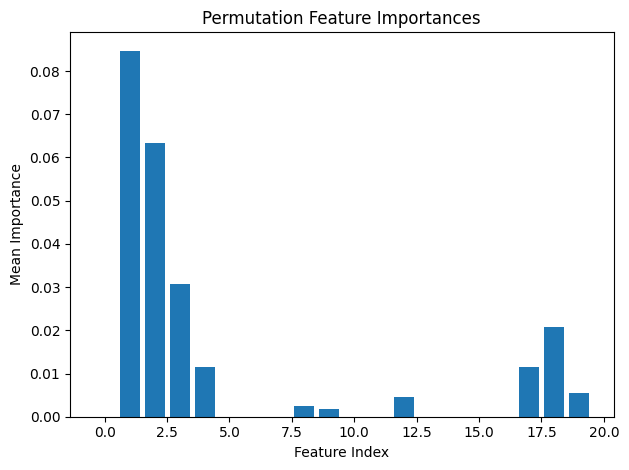

In [185]:
from sklearn.metrics import classification_report

print("The SMOTETomek undersampling technique was used.")

# Define the best model (MLP with specified hyperparameters)
best_model = MLPClassifier(
    hidden_layer_sizes=(6, 4),
    max_iter=20000,
    alpha=0.001,
    solver='adam',
    learning_rate_init=0.0001,
    random_state=42,
)

# Resampling strategy
resampling_strategy = SMOTETomek(random_state=42)

# Complete pipeline with preprocessing and resampling
pipeline_best = ImbPipeline(steps=[
    ('column_transformer', column_transformer),
    ('resampling', resampling_strategy),
    ('model', best_model)
])

# Fit the pipeline to the training data
pipeline_best.fit(Xtrain, ytrain)

# Feature importance using permutation
importance = permutation_importance(pipeline_best, Xtrain, ytrain, n_repeats=10)

# Generate predictions and report
y_pred = pipeline_best.predict(Xtest)
print(classification_report(ytest, y_pred))

# Display permutation importances
for i, imp in enumerate(importance.importances_mean):
    std = importance.importances_std[i]
    print(f"Feature {i}: {imp:.4f} ± {std:.4f}")

# Plot importance
plt.bar(range(len(importance.importances_mean)), importance.importances_mean)
plt.title("Permutation Feature Importances")
plt.xlabel("Feature Index")
plt.ylabel("Mean Importance")
plt.tight_layout()
plt.show()


**Observation:**

The final model, an MLP classifier trained with SMOTETomek, achieved a test accuracy of 67%. It showed stronger performance on the majority class (precision: 0.80, recall: 0.71), but lower recall on the minority class (0.58), which may lead to some false negatives. Permutation importance indicates that only a few features had meaningful impact, suggesting potential redundancy or irrelevance in others.

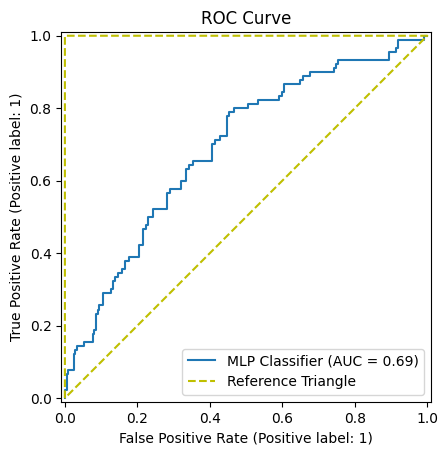

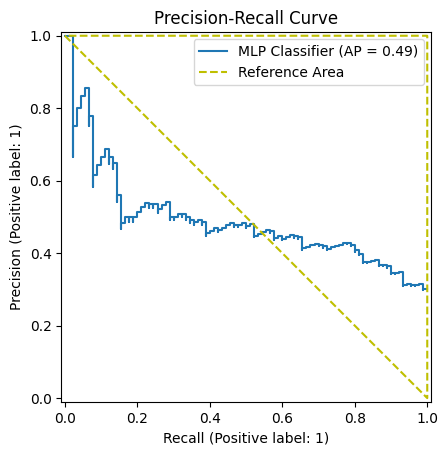

In [186]:
# Plotting ROC and Precision-Recall curves for the selected final pipeline.

# ROC Curve
roc_display = RocCurveDisplay.from_estimator(pipeline_best, Xtest, ytest, name='MLP Classifier')
plt.plot([0, 0, 1, 0], [0, 1, 1, 0], 'y--', label='Reference Triangle')
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision-Recall Curve
PrecisionRecallDisplay.from_estimator(pipeline_best, Xtest, ytest, name='MLP Classifier')
plt.plot([0, 1, 1, 0], [1, 0, 1, 1], 'y--', label='Reference Area')
plt.title("Precision-Recall Curve")
plt.legend(loc="upper right")
plt.show()



**Observation:**

The ROC AUC score of 0.69 suggests the classifier has moderate discrimination ability between classes. However, the average precision (AP) of 0.49 indicates limited performance in correctly identifying the minority class. This highlights the challenge of imbalanced classification despite resampling and careful model tuning.

In [187]:
evaluate_model(pipeline_best, "MLP Best Model", Xtv, ytv, resampling_strategy)

>> MLP Best Model
	 test_accuracy 0.6957 (0.027)
	 train_accuracy 0.7217 (0.012)
	 test_precision 0.4948 (0.038)
	 train_precision 0.5313 (0.018)
	 test_recall 0.5900 (0.049)
	 train_recall 0.6272 (0.023)
	 test_f1 0.5377 (0.039)
	 train_f1 0.5749 (0.013)
	 test_roc_auc 0.7164 (0.027)
	 train_roc_auc 0.7553 (0.011)
	 test_gmean 0.6606 (0.032)
	 train_gmean 0.6912 (0.011)


**Conclusion**

The evaluation focused on Recall, Precision, and F1-score, prioritizing the identification of bad clients (minority class) through Recall to mitigate financial risk. Precision was then considered to avoid rejecting too many good clients. Among all models, the MLP classifier achieved the best balance across these metrics, with the highest F1-score.

Additionally, overfitting was ruled out by ensuring that metric differences between training and validation sets remained below 3%.
